# Classification of Pneumonia Chest X-rays using CNN

In [100]:
# Import the libraries

import os
from glob import glob
import random
import cv2
import numpy as np
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
%matplotlib inline

# Keras libraries
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
from keras.models import Sequential
from keras.layers import Activation, Dense, Conv2D, MaxPooling2D, Flatten
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks.tensorboard_v1 import TensorBoard
import keras_metrics

## Load and explore the images

The data is stored in the Xray folder in 3 sub-folders - train, val and test. Each of them has a subfolder each for NORMAL and PNEUMONIA. The path to these folders are stored in variables and used to load the data.

In [2]:
print(os.listdir("Xray"))

['.ipynb_checkpoints', 'val', 'train', 'test']


In [3]:
# path to the folder

train_folder = "Xray/train"
val_folder = "Xray/val"
test_folder = "Xray/test"

In [4]:
# import the Normal and Pneumonia images of training set

train_data_N = glob(train_folder+"/NORMAL/*.jpeg")
train_data_P = glob(train_folder+"/PNEUMONIA/*.jpeg")

In [5]:
# load the first image of each type.

img_normal = load_img(train_data_N[0])
img_sick = load_img(train_data_P[0])

NORMAL


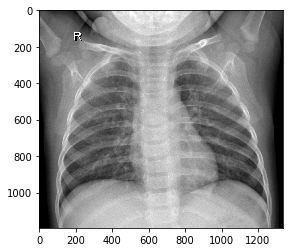

In [7]:
print('NORMAL')
plt.imshow(img_normal)
plt.show()

In [6]:
# print the mode, size of the image

print(type(img_normal))
print(img_normal.format)
print(img_normal.mode)
print(img_normal.size)

<class 'PIL.Image.Image'>
None
RGB
(1338, 1194)


PNEUMONIA


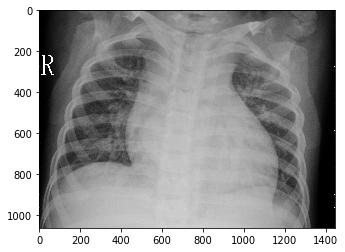

In [9]:
print('PNEUMONIA')
plt.imshow(img_sick)
plt.show()

In [8]:
# print the mode, size of the image

print(type(img_sick))
print(img_sick.format)
print(img_sick.mode)
print(img_sick.size)

<class 'PIL.Image.Image'>
None
RGB
(1448, 1064)


The size of the images are different in the 2 images and they are in RGB mode i.e., 3 channels.

In [12]:
# print the number of images in each class of the training set

print('Number of Normal xrays in training set: ' + str(len(train_data_N)))
print('Number of Pneumonia xrays in training set: ' + str(len(train_data_P)))
print('Total Number of xrays in training set: ' + str(len(train_data_N +train_data_P)))

Number of Normal xrays in training set: 1341
Number of Pneumonia xrays in training set: 3875
Total Number of xrays in training set: 5216


Text(0, 0.5, 'Count')

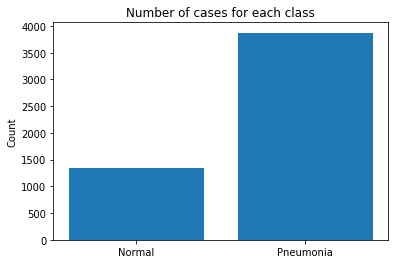

In [13]:
# Plot the number of images in each class in the training set

classes = ['Normal', 'Pneumonia']
counts = [len(train_data_N),len(train_data_P)]
plt.bar(classes, counts)
plt.title('Number of cases for each class')
plt.ylabel('Count')

In [14]:
# import the validation data

val_data_N = glob(val_folder+"/NORMAL/*.jpeg")
val_data_P = glob(val_folder+"/PNEUMONIA/*.jpeg")

In [15]:
# print the number of images in the validation data

print('Number of Normal xrays in validation set: ' + str(len(val_data_N)))
print('Number of Pneumonia xrays in validation set: ' + str(len(val_data_P)))
print('Total Number of xrays in validation set: ' + str(len(val_data_N+val_data_P)))

Number of Normal xrays in validation set: 8
Number of Pneumonia xrays in validation set: 8
Total Number of xrays in validation set: 16


In [16]:
# import the test data

test_data_N = glob(test_folder+"/NORMAL/*.jpeg")
test_data_P = glob(test_folder+"/PNEUMONIA/*.jpeg")

In [17]:
# print the number of images in the test data

print('Number of Normal xrays in test set: ' + str(len(test_data_N)))
print('Number of Pneumonia xrays in test set: ' + str(len(test_data_P)))
print('Total Number of xrays in test set: ' + str(len(test_data_N+test_data_P)))

Number of Normal xrays in test set: 234
Number of Pneumonia xrays in test set: 390
Total Number of xrays in test set: 624


The following function checks the minimum and maximum pixel sizes of all the images to see the range in the difference.

In [18]:
def find_pixel_size(list_data):
    "Finds the min and max of the sizes of each image in a list"
    
    pixels = [(np.asarray(plt.imread(i)).shape) for i in list_data]
    return ("Min: " + str(min(pixels)), "Max: " + str(max(pixels)))

In [118]:
print('Min and Max pixel sizes in the Normal training set')
find_pixel_size(train_data_N)

Min and Max pixel sizes in the Normal training set


('Min: (672, 912)', 'Max: (2663, 2373)')

In [119]:
print('Min and Max pixel sizes in the Pneumonia training set')
find_pixel_size(train_data_P)

Min and Max pixel sizes in the Pneumonia training set


('Min: (127, 384, 3)', 'Max: (2304, 2160)')

In [120]:
print('Min and Max pixel sizes in the Normal validation set')
find_pixel_size(val_data_N)

Min and Max pixel sizes in the Normal validation set


('Min: (928, 1288)', 'Max: (1416, 1776)')

In [121]:
print('Min and Max pixel sizes in the Pneumonia validation set')
find_pixel_size(val_data_P)

Min and Max pixel sizes in the Pneumonia validation set


('Min: (592, 968)', 'Max: (1128, 1664)')

In [122]:
print('Min and Max pixel sizes in the Normal test set')
find_pixel_size(test_data_N)

Min and Max pixel sizes in the Normal test set


('Min: (496, 984)', 'Max: (2713, 2517)')

In [123]:
print('Min and Max pixel sizes in the Pneumonia test set')
find_pixel_size(test_data_P)

Min and Max pixel sizes in the Pneumonia test set


('Min: (344, 888)', 'Max: (1456, 2000)')


From the above data analyses, we observe the following:

1) The pixel sizes of the images are different. On analysing the other files, the pixel sizes are all different. They need to be the same if we are using a fully connected layer in the neural network model. 

2) We also see that this is an imbalanced data set - the number of pneumonia xrays is way more than the normal xrays. We can use SMOTE to balance the data set - an oversampling technique that generates synthetic samples from the minority class. This means that the images have to be resized and converted to an array before oversampling as SMOTE takes the images represented as an array.  

3) All the images are in RGB mode.

## Data Wrangling and Preprocessing - Resizing, SMOTE

Create directories in the current folder to hold the resized images for visualisations. 

In [110]:
# Check if the directory exists and if not, create it.

p = os.getcwd()

dirs = ['trainN', 'trainP', 'valN', 'valP', 'testN', 'testP']
for i in dirs:
    if not os.path.exists(p+'/'+i):
        os.mkdir(i)
    else:
        print('Directory exists')

Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists


The images were resized to 128,128 pixel size. The following function loads the image from the list, resizes it and writes it to another folder in the current directory.

In [26]:
def resize_image(l,folder):
    "resize images in a list and return the new image in another folder"
    count = 1
    for name in l:
        image = cv2.imread(name)
        image = cv2.resize(image, (128, 128))
        cv2.imwrite(folder+'/resized_' +str(count) +'.jpeg', image)
        count += 1
    return

The resized train data - both Normal and Pneumonia - are taken from their individual folders, imported into a list format and then joined to get a single train set. The images in this set are then converted into a numpy array and then stored in trainx. The labels for this training set is made by creating a y_train, by appending the values for each Normal file as 0 and Pneumonia as 1.

In [27]:
# resize the images in normal training set

resize_image(train_data_N, 'trainN')

In [28]:
# resize images in Pneumonia training set

resize_image(train_data_P, 'trainP')

In [33]:
# Import the resized images

trainN = glob('trainN/*.jpeg')
trainP = glob('trainP/*.jpeg')

In [34]:
# Join the Normal and Pneumonia sets into a single list

train = trainN + trainP

In [35]:
# Each image in the list is converted to an array and stored in trainx

trainx = []
for i in train:
    img = load_img(i)
    # convert to numpy array
    img_array = img_to_array(img)
    trainx.append(img_array)

In [40]:
# The labels for the train set is made by appending 0 for a normal image and 1 for pneumonia image

y_train = []

for i in trainN:
    y_train.append(0)
for i in trainP:
    y_train.append(1)

In [111]:
# Convert the trainx into an array

trainx = np.array(trainx)
trainx.shape

(5216, 128, 128, 3)

In [39]:
# The shape of the trainx is (n_samples, width, height, channels). For SMOTE, the last 3 are combined to be the 
# features and multiplied to give the shape as a 2D flat shape.

s = trainx.shape[1]*trainx.shape[2]*trainx.shape[3]
X_trainFlat = trainx.reshape(trainx.shape[0], s)

49152

In [43]:
# y_train is also converted to array

Y_train = np.array(y_train)

In [44]:
# Initiate the SMOTE

sm = SMOTE(random_state=42)

In [45]:
# Fit the SMOTE on the flat training set and the Y_train.

trainX_smote, trainY_smote = sm.fit_resample(X_trainFlat, Y_train)

In [50]:
# Check the number of Normal cases in the SMOTEd data - it has gone up from 1341 to match the no. of Pneumonia cases
# which is 3875

(trainY_smote == 0).sum()

3875

In [47]:
trainX_smote.shape

(7750, 49152)

Text(0, 0.5, 'Count')

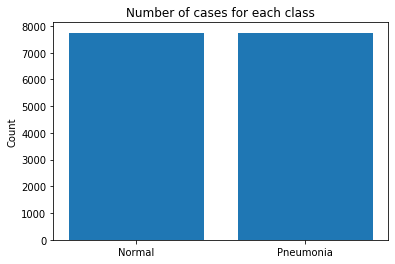

In [66]:
# Plotting the distribution of the classes in the training set.

classes = ['Normal', 'Pneumonia']
counts = [len(trainX_smote),len(trainY_smote)]
plt.bar(classes, counts)
plt.title('Number of cases for each class')
plt.ylabel('Count')

In [62]:
# Convert the flattened shape of the training set into the tuple with 4 values.

for i in range(len(trainX_smote)):
    height, width, channels = 128, 128, 3
    X_train_final = trainX_smote.reshape(len(trainX_smote), height, width, channels)

In [63]:
X_train_final.shape

(7750, 128, 128, 3)

<class 'PIL.JpegImagePlugin.JpegImageFile'>
JPEG
RGB
(128, 128)


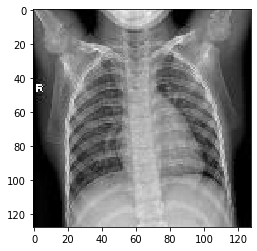

In [116]:
# Visualized one of the smoted samples by saving the array and loading the image again

a = X_train_final[0]
save_img('smoted.jpeg', a)
img = load_img('smoted.jpeg')

print(type(img))
print(img.format)
print(img.mode)
print(img.size)

plt.imshow(img)
plt.show()

The validation set and the test set are also resized and converted into an array with their respective labels. 

In [29]:
# resize the normal validation data

resize_image(val_data_N,'valN')

In [30]:
# resize the pneumonia validatin data

resize_image(val_data_P,'valP')

In [52]:
# Load the resized images and join to a single val list

valN = glob('valN/*.jpeg')
valP = glob('valP/*.jpeg')
val = valN + valP

In [54]:
# Convert each image in the val set to an array

valx = []
for i in val:
    img = load_img(i)
    # convert to numpy array
    img_array = img_to_array(img)
    valx.append(img_array)

In [64]:
# Convert the list of arrays into an array

X_val_final = np.array(valx)
valx.shape

(16, 128, 128, 3)

In [53]:
# Create the labels for the val set 

y_val = []

for i in valN:
    y_val.append(0)
for i in valP:
    y_val.append(1)

In [56]:
# Convert the y labels into an array

Y_val = np.array(y_val)

In [31]:
# resize the normal test data

resize_image(test_data_N,'testN')

In [32]:
# resize the pneumonia test data
resize_image(test_data_P,'testP')

In [57]:
# Load and join the test sets into single test set

testN = glob('testN/*.jpeg')
testP = glob('testP/*.jpeg')
test = testN + testP

In [58]:
# convert each image in the test set to an array

testx = []
for i in val:
    img = load_img(i)
    # convert to numpy array
    img_array = img_to_array(img)
    testx.append(img_array)

In [65]:
# Convert the list into an array

X_test_final = np.array(testx)
testx.shape

(16, 128, 128, 3)

In [59]:
# Create the labels for the test set

y_test = []

for i in testN:
    y_test.append(0)
for i in testP:
    y_test.append(1)

In [61]:
# Convert the labels into an array

Y_test = np.array(y_test)

## Model Architecture

I am using a Sequential CNN model for this problem. The different layers are, the Convolutional 2D layer with ReLU (Rectified Linear Unit) activation, MaxPooling2D layer, 2 Fully Connected layers and the output layer with SoftMax activation. The model is compiled with the Adam optimizer, loss function is binary crossentropy and the metrics used to evaluate is Accuracy. As this is now a balanced data set, Accuracy is acceptable.

In [94]:
# Optimizer

optimizer = optimizers.Adam(lr = 0.001)

In [97]:
# CNN model

cnn = Sequential()

# 1st Convolution
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(128, 128, 3), use_bias=True))

# 1st Pooling
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd Convolution
cnn.add(Conv2D(32, (3, 3), activation="relu", use_bias=True))

# 2nd Pooling layer
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# 3rd Convolution
cnn.add(Conv2D(16, (3, 3), activation="relu", use_bias=True))

# 3rd Pooling layer
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# 4th Convolution
cnn.add(Conv2D(8, (3, 3), activation="relu", use_bias=True))

# 4th Pooling layer
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# 5th Convolution
cnn.add(Conv2D(4, (3, 3), activation="relu", use_bias=True))

# 5th Pooling layer
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Flatten the layer
cnn.add(Flatten())

# Fully Connected Layers
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'softmax', units = 1))

# Compile the Neural network
cnn.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [98]:
cnn.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 61, 61, 32)        18464     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 28, 28, 16)        4624      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 12, 12, 8)       

## Data Augmentation, Data Generators and Callbacks

The function ImageDataGenerator augments the image by iterating through image as your CNN is getting ready to process that image. Here, I am rescaling and doing a horizontal_flip to the image. This allows for the model to generalise. The test set is only rescaled. 

In [124]:
# Initiate the ImageDataGenerators with the rescaling and flip for the train set and another one with just the 
# rescaling for the test set. This can also be used for the validation set.

train_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)  #Image normalization.

In [125]:
# Using the flow method of the ImageDataGenerator to load the images in an array. The test_datagen is used on the
# validation and test set data.

training_set = train_datagen.flow(X_train_final, Y_train, batch_size=32)

validation_set = test.datagen.flow(X_val_final, Y_val, batch_size=32)

test_set = test_datagen.flow(X_test_final, Y_test, batch_size=32)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/arunsn/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-125-8f3242a406ee>", line 4, in <module>
    training_set = train_datagen.flow(X_train_final, Y_train, batch_size=32)
  File "/home/arunsn/anaconda3/lib/python3.7/site-packages/keras/preprocessing/image.py", line 359, in flow
    subset=subset
  File "/home/arunsn/anaconda3/lib/python3.7/site-packages/keras/preprocessing/image.py", line 182, in __init__
    dtype=dtype)
  File "/home/arunsn/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/numpy_array_iterator.py", line 80, in __init__
    (np.asarray(x).shape, np.asarray(y).shape))
ValueError: `x` (images tensor) and `y` (labels) should have the same length. Found: x.shape = (7750, 128, 128, 3), y.shape = (5216,)

During handling of the above exception, another exception occurred:

Traceback (most

ValueError: `x` (images tensor) and `y` (labels) should have the same length. Found: x.shape = (7750, 128, 128, 3), y.shape = (5216,)

The callbacks for this model will be 1) Early Stopping Monitor - stops training when a monitored quantity has stopped improving, 2) ReduceLROnPlateau - reduces the learning rate when the metric has stopped improving and 3) TensorBoard - a visualization tool provided with TensorFlow, writes a log, which allows visualizing dynamic graphs of the training and test metrics, as well as activation histograms for the different layers in the model.

In [ ]:
# Define the callbacks

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience = 3, min_lr=0.001)

early_stopping_monitor = EarlyStopping(monitor = 'val_loss', patience = 3)

tensorboard = TensorBoard(log_dir='tlog', write_graph=True)

## Training the Network

In [ ]:
# Train the model on the data generated batch by batch by the ImageDataGenerator

model.fit_generator(training_set, 
                    steps_per_epoch=len(X_train_final) / 32, 
                    epochs=epochs,
                    validation_data = validation_set,
                    callbacks = [early_stopping_monitor, reduce_lr, tensorboard])

## Evaluate performance

In [ ]:
train_accu = model.evaluate_generator(training_set)

In [ ]:
print(f 'Test loss: {score[0]} / Test accuracy: {score[1]}')

## Predict on the test set

In [ ]:
test_accu = model.predict_generator(test_set)

In [ ]:
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

In [ ]:
#from imblearn.keras import BalancedBatchGenerator

In [ ]:
#training_generator = BalancedBatchGenerator(X_, y, datagen, sampler=SMOTE(), batch_size=32, random_state=42)